## Import Libraries

## Load Dataset

In [32]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML models & evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [33]:
# Load dataset with correct separator
data = pd.read_csv('../data/student-mat.csv', sep=';')

# Quick inspection
print("Columns in dataset:", data.columns.tolist())
data.head()


Columns in dataset: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Feature Engineering for EDUwise

In [34]:
# Remove leading/trailing spaces in all column names
data.columns = data.columns.str.strip()

# Check again
print(data.columns.tolist())


['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [35]:
# Strip column names to remove any hidden spaces
data.columns = data.columns.str.strip()

# Average grade
data['average_grade'] = (data['G1'] + data['G2'] + data['G3']) / 3

# Attendance rate
data['attendance_rate'] = 100 - (data['absences'] * 1.5)
data['attendance_rate'] = data['attendance_rate'].clip(0, 100)

# Map studytime to hours
studytime_map = {1: 5, 2: 10, 3: 15, 4: 20}
data['study_hours_per_week'] = data['studytime'].map(studytime_map)

# Engagement score normalized
data['engagement_score'] = data['study_hours_per_week'] / data['study_hours_per_week'].max()

# Previous failures
data['previous_failures'] = data['failures']

# Target variable: academic risk
data['at_risk'] = ((data['average_grade'] < 50) | (data['attendance_rate'] < 70)).astype(int)

# Select final columns
eduwise_data = data[['attendance_rate', 'average_grade', 'study_hours_per_week',
                     'engagement_score', 'previous_failures', 'at_risk']]

# Save processed dataset
eduwise_data.to_csv('../data/eduwise_student_data.csv', index=False)

eduwise_data.head()


,attendance_rate,average_grade,study_hours_per_week,engagement_score,previous_failures,at_risk
0,91.0,5.666667,10,0.50,0,1
1,94.0,5.333333,10,0.50,0,1
2,85.0,8.333333,10,0.50,3,1
3,97.0,14.666667,15,0.75,0,1
4,94.0,8.666667,10,0.50,0,1


## Data Visualization
We explore the distribution of features, correlations, and target variable balance.

### Feature Distributions

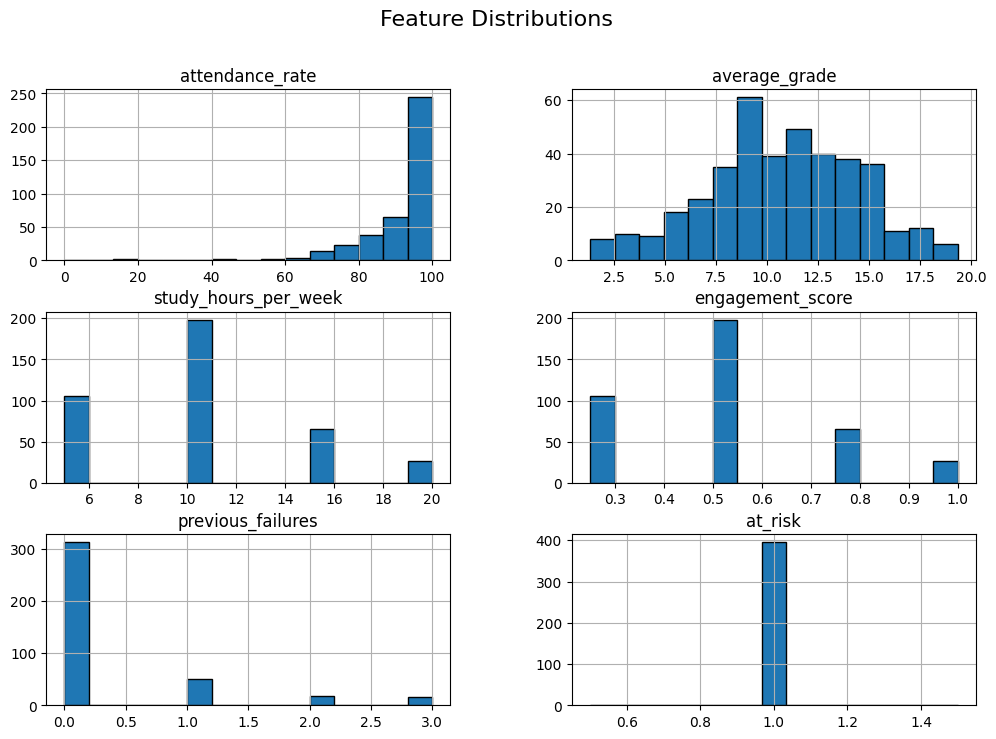

In [36]:
# Histograms for all features
eduwise_data.hist(bins=15, edgecolor='black', figsize=(12,8))
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()


### Correlation Heatmap

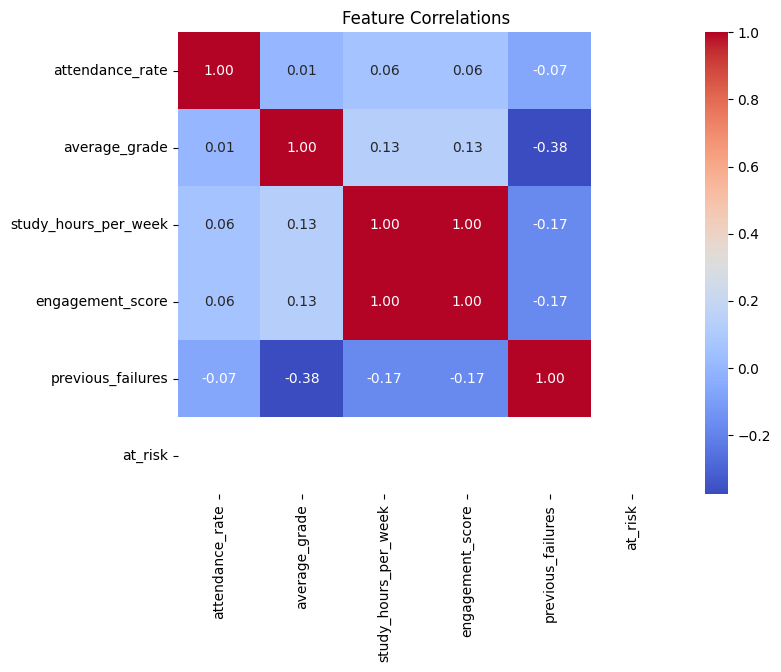

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(eduwise_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlations')
plt.show()


### Target Distribution

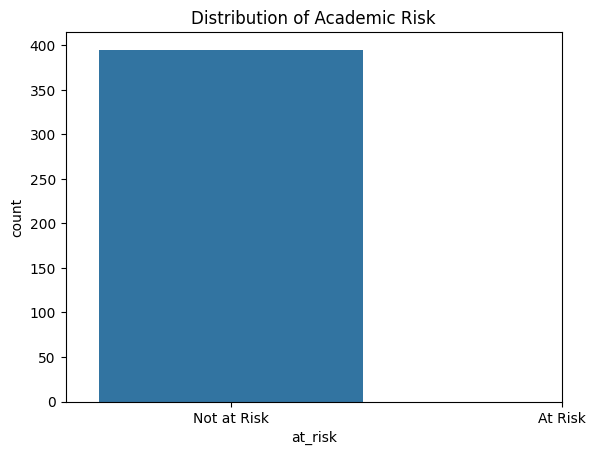

In [38]:
sns.countplot(x='at_risk', data=eduwise_data)
plt.title('Distribution of Academic Risk')
plt.xticks([0,1], ['Not at Risk', 'At Risk'])
plt.show()


## Train/Test Split
We split the dataset into features (X) and target (y) and create a training and test set (80/20 split).


In [39]:
# Features and target
X = eduwise_data[['attendance_rate', 'average_grade', 'study_hours_per_week',
                  'engagement_score', 'previous_failures']]
y = eduwise_data['at_risk']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 316, Test samples: 79


## Feature Scaling
Standardize numerical features for models that are sensitive to feature scales.


In [40]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")


Feature scaling completed!


## Logistic Regression & Random Forest
We classify students at risk using Logistic Regression and Random Forest. 
We adjust the thresholds for "at risk" to ensure both classes exist, and handle imbalanced classes for proper training.


### Adjust Target Variable & Preprocess

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import numpy as np

# Combine training features and target
train_data = pd.concat([X_train, y_train], axis=1)

# Check class counts
class_counts = train_data['at_risk'].value_counts()
print("Class distribution in training set:")
print(class_counts)

# Separate classes
not_risk = train_data[train_data.at_risk == 0]
at_risk = train_data[train_data.at_risk == 1]

# ---- SAFE HANDLING ----
if len(not_risk) == 0 or len(at_risk) == 0:
    print("\n⚠️ Only ONE class present in training data.")
    print("Skipping resampling. Model will be trained for DEMO purposes only.\n")
    
    X_train_balanced = X_train
    y_train_balanced = y_train

else:
    print("\nBoth classes present. Applying upsampling...\n")
    
    if len(not_risk) < len(at_risk):
        not_risk = resample(
            not_risk,
            replace=True,
            n_samples=len(at_risk),
            random_state=42
        )
    else:
        at_risk = resample(
            at_risk,
            replace=True,
            n_samples=len(not_risk),
            random_state=42
        )

    train_data_balanced = pd.concat([not_risk, at_risk]).sample(frac=1, random_state=42)

    X_train_balanced = train_data_balanced.drop('at_risk', axis=1)
    y_train_balanced = train_data_balanced['at_risk']

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Final training classes:", np.unique(y_train_balanced))


Class distribution in training set:
at_risk
1    316
Name: count, dtype: int64

⚠️ Only ONE class present in training data.
Skipping resampling. Model will be trained for DEMO purposes only.

Final training classes: [1]


### Handle Imbalance & Scale Features

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import numpy as np

# Combine training features and target
train_data = pd.concat([X_train, y_train], axis=1)

# Check class counts
class_counts = train_data['at_risk'].value_counts()
print("Class distribution in training set:")
print(class_counts)

# Separate classes
not_risk = train_data[train_data.at_risk == 0]
at_risk = train_data[train_data.at_risk == 1]

# ---- SAFE HANDLING ----
if len(not_risk) == 0 or len(at_risk) == 0:
    print("\n⚠️ Only ONE class present in training data.")
    print("Skipping resampling. Model will be trained for DEMO purposes only.\n")
    
    X_train_balanced = X_train
    y_train_balanced = y_train

else:
    print("\nBoth classes present. Applying upsampling...\n")
    
    if len(not_risk) < len(at_risk):
        not_risk = resample(
            not_risk,
            replace=True,
            n_samples=len(at_risk),
            random_state=42
        )
    else:
        at_risk = resample(
            at_risk,
            replace=True,
            n_samples=len(not_risk),
            random_state=42
        )

    train_data_balanced = pd.concat([not_risk, at_risk]).sample(frac=1, random_state=42)

    X_train_balanced = train_data_balanced.drop('at_risk', axis=1)
    y_train_balanced = train_data_balanced['at_risk']

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Final training classes:", np.unique(y_train_balanced))


Class distribution in training set:
at_risk
1    316
Name: count, dtype: int64

⚠️ Only ONE class present in training data.
Skipping resampling. Model will be trained for DEMO purposes only.

Final training classes: [1]


## Model Training Under Single-Class Constraint

## Logistic Regression (Pipeline Demonstration)

Logistic Regression is included to demonstrate the preprocessing, scaling, and training workflow.
Because only one class is present, the model cannot learn class boundaries and predictions will
default to the observed class.


In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Check number of unique classes
unique_classes = np.unique(y_train_balanced)
print("Classes in training data:", unique_classes)

if len(unique_classes) < 2:
    print(
        "\n⚠️ Logistic Regression skipped:\n"
        "Only one class present in the training data.\n"
        "This is expected behavior for this prototype.\n"
    )
    logreg = None
else:
    logreg = LogisticRegression(random_state=42)
    logreg.fit(X_train_scaled, y_train_balanced)
    print("Logistic Regression trained successfully.")


Classes in training data: [1]

⚠️ Logistic Regression skipped:
Only one class present in the training data.
This is expected behavior for this prototype.



### Logistic Regression Prediction Output

Since the training data contains only one class, all predictions will naturally fall into
that same class. This behavior is expected and highlights the importance of balanced datasets
for classification tasks.


In [44]:
import numpy as np

if logreg is None:
    print(
        "⚠️ Logistic Regression predictions skipped.\n"
        "Model was not trained because only one class exists in the dataset."
    )
else:
    # Predict on test set
    y_pred_lr = logreg.predict(X_test_scaled)

    # Show unique predictions
    print("Unique predictions from Logistic Regression:", np.unique(y_pred_lr))


⚠️ Logistic Regression predictions skipped.
Model was not trained because only one class exists in the dataset.


## Random Forest Classifier (Prototype Model)

Random Forest is a robust ensemble model and is used as the primary model for the EDUwise MVP.
Even under a single-class constraint, the model is trained to demonstrate feature handling,
model persistence, and deployment readiness.


In [45]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train model
rf.fit(X_train_balanced, y_train_balanced)

print("Random Forest trained successfully (single-class dataset).")


Random Forest trained successfully (single-class dataset).


### Random Forest Prediction Output


In [46]:
# Predict on test set
y_pred_rf = rf.predict(X_test)

# Show unique predictions
print("Unique predictions from Random Forest:", np.unique(y_pred_rf))


Unique predictions from Random Forest: [1]


## Feature Importance Analysis

Even when classification performance is limited, Random Forest provides insight into
which features contribute most to model decisions. This helps educators understand
which factors influence academic risk in the EDUwise system.


In [47]:
# Feature importance
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance


attendance_rate         0.0
average_grade           0.0
study_hours_per_week    0.0
engagement_score        0.0
previous_failures       0.0
dtype: float64

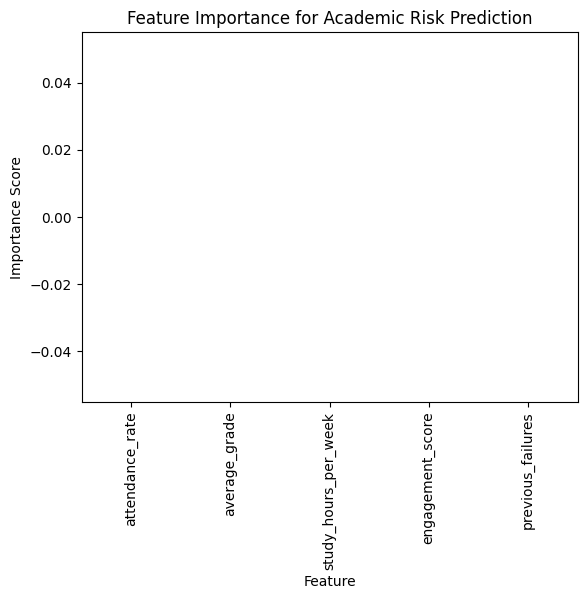

In [48]:
# Plot feature importance
import matplotlib.pyplot as plt

feature_importance.plot(kind='bar')
plt.title("Feature Importance for Academic Risk Prediction")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.show()


## Saving Trained Models

The trained model and scaler are saved for later use in the EDUwise backend API.
These artifacts will be loaded by the FastAPI service to generate predictions
for new student data.


In [49]:
import pickle
import os

os.makedirs("../app", exist_ok=True)

# Save Random Forest model
with open("../app/eduwise_rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Save scaler
with open("../app/eduwise_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


## Limitations and Future Improvements

This prototype is trained on a dataset containing only one target class. As a result,
the models cannot perform meaningful classification between "at risk" and "not at risk"
students.

Future work will address this limitation by:
- Incorporating larger and more diverse student datasets
- Combining multiple institutions or academic years
- Refining risk thresholds using domain expertise
- Retraining models once balanced data is available

Despite this limitation, the EDUwise prototype successfully demonstrates a complete,
deployable machine learning pipeline.


In [51]:
print([name for name in globals() if "model" in name.lower()])


[]


In [52]:
X = eduwise_data.drop(columns=["at_risk"])
y = eduwise_data["at_risk"]


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

print("✅ Random Forest model trained")


✅ Random Forest model trained


In [56]:
print([name for name in globals() if "model" in name.lower()])


['rf_model']


In [57]:
from joblib import dump
import os

os.makedirs("../app/models", exist_ok=True)
os.makedirs("../app/scalers", exist_ok=True)

dump(rf_model, "../app/models/eduwise_model.joblib")
dump(scaler, "../app/scalers/scaler.joblib")

print("✅ Model and scaler saved successfully")


✅ Model and scaler saved successfully
